In [1]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 3.2 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder, MNIST
from torchvision import transforms
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter

In [3]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])

In [4]:
batch_size = 32
data_loader = torch.utils.data.DataLoader(MNIST('data', train=True, download=True, transform=transform),
                                          batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 79026552.55it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 87399490.49it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28113836.80it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22023732.68it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [7]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [8]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [9]:
writer = SummaryWriter()

In [10]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [11]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [12]:
num_epochs = 50
n_critic = 5
display_step = 50
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch), end=' ')
    for i, (images, labels) in enumerate(data_loader):
        
        step = epoch * len(data_loader) + i + 1
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        
        d_loss = 0
        for _ in range(n_critic):
            d_loss = discriminator_train_step(len(real_images), discriminator,
                                              generator, d_optimizer, criterion,
                                              real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        
        writer.add_scalars('scalars', {'g_loss': g_loss, 'd_loss': (d_loss / n_critic)}, step)  
        
        if step % display_step == 0:
            generator.eval()
            z = Variable(torch.randn(9, 100)).cuda()
            labels = Variable(torch.LongTensor(np.arange(9))).cuda()
            sample_images = generator(z, labels).unsqueeze(1)
            grid = make_grid(sample_images, nrow=3, normalize=True)
            writer.add_image('sample_image', grid, step)
    print('Done!')

Starting epoch 0... Done!
Starting epoch 1... Done!
Starting epoch 2... Done!
Starting epoch 3... Done!
Starting epoch 4... Done!
Starting epoch 5... Done!
Starting epoch 6... Done!
Starting epoch 7... Done!
Starting epoch 8... Done!
Starting epoch 9... Done!
Starting epoch 10... Done!
Starting epoch 11... Done!
Starting epoch 12... Done!
Starting epoch 13... Done!
Starting epoch 14... Done!
Starting epoch 15... Done!
Starting epoch 16... Done!
Starting epoch 17... Done!
Starting epoch 18... Done!
Starting epoch 19... Done!
Starting epoch 20... Done!
Starting epoch 21... Done!
Starting epoch 22... Done!
Starting epoch 23... Done!
Starting epoch 24... Done!
Starting epoch 25... Done!
Starting epoch 26... Done!
Starting epoch 27... Done!
Starting epoch 28... Done!
Starting epoch 29... Done!
Starting epoch 30... Done!
Starting epoch 31... Done!
Starting epoch 32... Done!
Starting epoch 33... Done!
Starting epoch 34... Done!
Starting epoch 35... Done!
Starting epoch 36... Done!
Starting ep

In [13]:
torch.save(generator.state_dict(), 'generator_state.pt')

In [14]:
z = Variable(torch.randn(100, 100)).cuda()
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).cuda()

In [15]:
images = generator(z, labels).unsqueeze(1)

In [16]:
grid = make_grid(images, nrow=10, normalize=True)

(-0.5, 301.5, 301.5, -0.5)

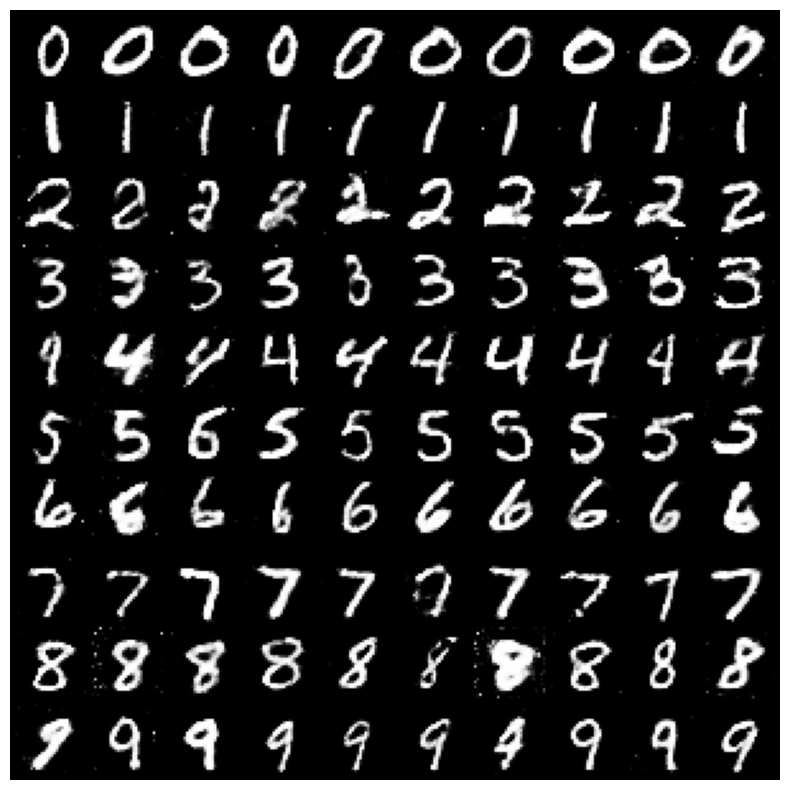

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1, 2, 0).cpu().data, cmap='binary')
ax.axis('off')

In [19]:
def generate_digit(generator, digit):
    z = Variable(torch.randn(1, 100)).cuda()
    label = torch.LongTensor([digit]).cuda()
    img = generator(z, label).data.cpu()
    img = 0.5 * img + 0.5
    return transforms.ToPILImage()(img)

In [34]:
generate_digit(generator, 8)

## <b>Assignment</b>

In [36]:
import os

dataset_folder = "custom_dataset_1"

for i in range(10):
    os.system(f"mkdir -p {dataset_folder}/train/{i}")

In [37]:
num_classes = 10

for c in range(num_classes):
    for i in range(3):
        sample = generate_digit(generator, c)
        sample = sample.save(f"{dataset_folder}/train/{c}/{i}.png")

In [29]:
from torch.nn import Module
from torch import nn


class Model(Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y

In [32]:
import numpy as np
import os
import torch
from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch_size = 256
    train_dataset = mnist.MNIST(root='./train', train=True, transform=ToTensor(), download=True)
    test_dataset = mnist.MNIST(root='./test', train=False, transform=ToTensor(), download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    model = Model().to(device)
    sgd = SGD(model.parameters(), lr=1e-1)
    loss_fn = CrossEntropyLoss()
    all_epoch = 100
    prev_acc = 0
    for current_epoch in range(all_epoch):
        model.train()
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)
            sgd.zero_grad()
            predict_y = model(train_x.float())
            loss = loss_fn(predict_y, train_label.long())
            loss.backward()
            sgd.step()

        all_correct_num = 0
        all_sample_num = 0
        model.eval()
        
        for idx, (test_x, test_label) in enumerate(test_loader):
            test_x = test_x.to(device)
            test_label = test_label.to(device)
            predict_y = model(test_x.float()).detach()
            predict_y =torch.argmax(predict_y, dim=-1)
            current_correct_num = predict_y == test_label
            all_correct_num += np.sum(current_correct_num.to('cpu').numpy(), axis=-1)
            all_sample_num += current_correct_num.shape[0]
        acc = all_correct_num / all_sample_num
        print('accuracy: {:.3f}'.format(acc), flush=True)
        if not os.path.isdir("models"):
            os.mkdir("models")
        torch.save(model, 'models/mnist_{:.3f}.pkl'.format(acc))
        if np.abs(acc - prev_acc) < 1e-4:
            break
        prev_acc = acc
    print("Model finished training")

accuracy: 0.866
accuracy: 0.883
accuracy: 0.921
accuracy: 0.949
accuracy: 0.962
accuracy: 0.971
accuracy: 0.977
accuracy: 0.978
accuracy: 0.979
accuracy: 0.980
accuracy: 0.981
accuracy: 0.982
accuracy: 0.982
accuracy: 0.983
accuracy: 0.982
accuracy: 0.981
accuracy: 0.981
Model finished training


In [48]:
import numpy as np
import os
import torch
import torchvision.datasets as datasets
from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 16

train_dataset = datasets.ImageFolder(root=f"{dataset_folder}/train/",
                                     transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor()]))
# train_dataset = mnist.MNIST(root='./train', train=True, transform=ToTensor(), download=True)
test_dataset = mnist.MNIST(root='./test', train=False, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model = Model().to(device)
sgd = SGD(model.parameters(), lr=1e-1)
loss_fn = CrossEntropyLoss()
all_epoch = 200
prev_acc = 0

for current_epoch in range(all_epoch):
    model.train()
    print("Epoch:", current_epoch)
    for idx, (train_x, train_label) in enumerate(train_loader):
        train_x = train_x.to(device)
        train_label = train_label.to(device)
        sgd.zero_grad()
        predict_y = model(train_x.float())
        loss = loss_fn(predict_y, train_label.long())
        loss.backward()
        sgd.step()

    all_correct_num = 0
    all_sample_num = 0
    model.eval()
    
    for idx, (test_x, test_label) in enumerate(test_loader):
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model(test_x.float()).detach()
        predict_y =torch.argmax(predict_y, dim=-1)
        current_correct_num = predict_y == test_label
        all_correct_num += np.sum(current_correct_num.to('cpu').numpy(), axis=-1)
        all_sample_num += current_correct_num.shape[0]
    acc = all_correct_num / all_sample_num
    print('accuracy: {:.3f}'.format(acc), flush=True)
    if not os.path.isdir("models"):
        os.mkdir("models")
    torch.save(model, 'models/mnist_{:.3f}.pkl'.format(acc))
    # if np.abs(acc - prev_acc) < 1e-4:
    #    break
    prev_acc = acc

print("Model finished training")

Epoch: 0
accuracy: 0.122
Epoch: 1
accuracy: 0.131
Epoch: 2
accuracy: 0.132
Epoch: 3
accuracy: 0.125
Epoch: 4
accuracy: 0.116
Epoch: 5
accuracy: 0.107
Epoch: 6
accuracy: 0.104
Epoch: 7
accuracy: 0.103
Epoch: 8
accuracy: 0.103
Epoch: 9
accuracy: 0.103
Epoch: 10
accuracy: 0.103
Epoch: 11
accuracy: 0.105
Epoch: 12
accuracy: 0.105
Epoch: 13
accuracy: 0.110
Epoch: 14
accuracy: 0.112
Epoch: 15
accuracy: 0.119
Epoch: 16
accuracy: 0.126
Epoch: 17
accuracy: 0.125
Epoch: 18
accuracy: 0.139
Epoch: 19
accuracy: 0.138
Epoch: 20
accuracy: 0.153
Epoch: 21
accuracy: 0.152
Epoch: 22
accuracy: 0.170
Epoch: 23
accuracy: 0.161
Epoch: 24
accuracy: 0.176
Epoch: 25
accuracy: 0.199
Epoch: 26
accuracy: 0.208
Epoch: 27
accuracy: 0.252
Epoch: 28
accuracy: 0.283
Epoch: 29
accuracy: 0.305
Epoch: 30
accuracy: 0.334
Epoch: 31
accuracy: 0.354
Epoch: 32
accuracy: 0.370
Epoch: 33
accuracy: 0.388
Epoch: 34
accuracy: 0.398
Epoch: 35
accuracy: 0.402
Epoch: 36
accuracy: 0.405
Epoch: 37
accuracy: 0.411
Epoch: 38
accuracy: 0.

In [49]:
import os

dataset_folder = "custom_dataset_2"

for i in range(10):
    os.system(f"mkdir -p {dataset_folder}/train/{i}")

num_classes = 10

for c in range(num_classes):
    for i in range(3):
        sample = generate_digit(generator, c)
        sample = sample.save(f"{dataset_folder}/train/{c}/{i}.png")

In [51]:
import numpy as np
import os
import torch
import torchvision.datasets as datasets
from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 16

train_dataset = datasets.ImageFolder(root=f"{dataset_folder}/train/",
                                     transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor()]))
# train_dataset = mnist.MNIST(root='./train', train=True, transform=ToTensor(), download=True)
test_dataset = mnist.MNIST(root='./test', train=False, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model = Model().to(device)
sgd = SGD(model.parameters(), lr=1e-1)
loss_fn = CrossEntropyLoss()
all_epoch = 200
prev_acc = 0

for current_epoch in range(all_epoch):
    model.train()
    print("Epoch:", current_epoch)
    for idx, (train_x, train_label) in enumerate(train_loader):
        train_x = train_x.to(device)
        train_label = train_label.to(device)
        sgd.zero_grad()
        predict_y = model(train_x.float())
        loss = loss_fn(predict_y, train_label.long())
        loss.backward()
        sgd.step()

    all_correct_num = 0
    all_sample_num = 0
    model.eval()
    
    for idx, (test_x, test_label) in enumerate(test_loader):
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model(test_x.float()).detach()
        predict_y =torch.argmax(predict_y, dim=-1)
        current_correct_num = predict_y == test_label
        all_correct_num += np.sum(current_correct_num.to('cpu').numpy(), axis=-1)
        all_sample_num += current_correct_num.shape[0]
    acc = all_correct_num / all_sample_num
    print('accuracy: {:.3f}'.format(acc), flush=True)
    if not os.path.isdir("models"):
        os.mkdir("models")
    torch.save(model, 'models/mnist_{:.3f}.pkl'.format(acc))
    # if np.abs(acc - prev_acc) < 1e-4:
    #    break
    prev_acc = acc

print("Model finished training")

Epoch: 0
accuracy: 0.105
Epoch: 1
accuracy: 0.131
Epoch: 2
accuracy: 0.148
Epoch: 3
accuracy: 0.143
Epoch: 4
accuracy: 0.128
Epoch: 5
accuracy: 0.112
Epoch: 6
accuracy: 0.104
Epoch: 7
accuracy: 0.102
Epoch: 8
accuracy: 0.101
Epoch: 9
accuracy: 0.102
Epoch: 10
accuracy: 0.104
Epoch: 11
accuracy: 0.109
Epoch: 12
accuracy: 0.113
Epoch: 13
accuracy: 0.118
Epoch: 14
accuracy: 0.123
Epoch: 15
accuracy: 0.128
Epoch: 16
accuracy: 0.133
Epoch: 17
accuracy: 0.139
Epoch: 18
accuracy: 0.147
Epoch: 19
accuracy: 0.154
Epoch: 20
accuracy: 0.162
Epoch: 21
accuracy: 0.167
Epoch: 22
accuracy: 0.172
Epoch: 23
accuracy: 0.175
Epoch: 24
accuracy: 0.178
Epoch: 25
accuracy: 0.182
Epoch: 26
accuracy: 0.186
Epoch: 27
accuracy: 0.189
Epoch: 28
accuracy: 0.194
Epoch: 29
accuracy: 0.200
Epoch: 30
accuracy: 0.206
Epoch: 31
accuracy: 0.206
Epoch: 32
accuracy: 0.211
Epoch: 33
accuracy: 0.214
Epoch: 34
accuracy: 0.215
Epoch: 35
accuracy: 0.219
Epoch: 36
accuracy: 0.224
Epoch: 37
accuracy: 0.225
Epoch: 38
accuracy: 0.

In [52]:
import os

dataset_folder = "custom_dataset_3"

for i in range(10):
    os.system(f"mkdir -p {dataset_folder}/train/{i}")

num_classes = 10

for c in range(num_classes):
    for i in range(3):
        sample = generate_digit(generator, c)
        sample = sample.save(f"{dataset_folder}/train/{c}/{i}.png")

In [53]:
import numpy as np
import os
import torch
import torchvision.datasets as datasets
from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 16

train_dataset = datasets.ImageFolder(root=f"{dataset_folder}/train/",
                                     transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor()]))
# train_dataset = mnist.MNIST(root='./train', train=True, transform=ToTensor(), download=True)
test_dataset = mnist.MNIST(root='./test', train=False, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model = Model().to(device)
sgd = SGD(model.parameters(), lr=1e-1)
loss_fn = CrossEntropyLoss()
all_epoch = 200
prev_acc = 0

for current_epoch in range(all_epoch):
    model.train()
    print("Epoch:", current_epoch)
    for idx, (train_x, train_label) in enumerate(train_loader):
        train_x = train_x.to(device)
        train_label = train_label.to(device)
        sgd.zero_grad()
        predict_y = model(train_x.float())
        loss = loss_fn(predict_y, train_label.long())
        loss.backward()
        sgd.step()

    all_correct_num = 0
    all_sample_num = 0
    model.eval()
    
    for idx, (test_x, test_label) in enumerate(test_loader):
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model(test_x.float()).detach()
        predict_y =torch.argmax(predict_y, dim=-1)
        current_correct_num = predict_y == test_label
        all_correct_num += np.sum(current_correct_num.to('cpu').numpy(), axis=-1)
        all_sample_num += current_correct_num.shape[0]
    acc = all_correct_num / all_sample_num
    print('accuracy: {:.3f}'.format(acc), flush=True)
    if not os.path.isdir("models"):
        os.mkdir("models")
    torch.save(model, 'models/mnist_{:.3f}.pkl'.format(acc))
    # if np.abs(acc - prev_acc) < 1e-4:
    #    break
    prev_acc = acc

print("Model finished training")

Epoch: 0
accuracy: 0.089
Epoch: 1
accuracy: 0.089
Epoch: 2
accuracy: 0.089
Epoch: 3
accuracy: 0.089
Epoch: 4
accuracy: 0.089
Epoch: 5
accuracy: 0.089
Epoch: 6
accuracy: 0.089
Epoch: 7
accuracy: 0.089
Epoch: 8
accuracy: 0.089
Epoch: 9
accuracy: 0.089
Epoch: 10
accuracy: 0.089
Epoch: 11
accuracy: 0.089
Epoch: 12
accuracy: 0.089
Epoch: 13
accuracy: 0.089
Epoch: 14
accuracy: 0.089
Epoch: 15
accuracy: 0.089
Epoch: 16
accuracy: 0.089
Epoch: 17
accuracy: 0.089
Epoch: 18
accuracy: 0.089
Epoch: 19
accuracy: 0.089
Epoch: 20
accuracy: 0.088
Epoch: 21
accuracy: 0.090
Epoch: 22
accuracy: 0.091
Epoch: 23
accuracy: 0.099
Epoch: 24
accuracy: 0.111
Epoch: 25
accuracy: 0.124
Epoch: 26
accuracy: 0.142
Epoch: 27
accuracy: 0.157
Epoch: 28
accuracy: 0.169
Epoch: 29
accuracy: 0.181
Epoch: 30
accuracy: 0.191
Epoch: 31
accuracy: 0.200
Epoch: 32
accuracy: 0.200
Epoch: 33
accuracy: 0.201
Epoch: 34
accuracy: 0.201
Epoch: 35
accuracy: 0.195
Epoch: 36
accuracy: 0.192
Epoch: 37
accuracy: 0.187
Epoch: 38
accuracy: 0.

In [54]:
import os

dataset_folder = "custom_dataset_4"

for i in range(10):
    os.system(f"mkdir -p {dataset_folder}/train/{i}")

num_classes = 10

for c in range(num_classes):
    for i in range(3):
        sample = generate_digit(generator, c)
        sample = sample.save(f"{dataset_folder}/train/{c}/{i}.png")

In [55]:
import numpy as np
import os
import torch
import torchvision.datasets as datasets
from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 16

train_dataset = datasets.ImageFolder(root=f"{dataset_folder}/train/",
                                     transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor()]))
# train_dataset = mnist.MNIST(root='./train', train=True, transform=ToTensor(), download=True)
test_dataset = mnist.MNIST(root='./test', train=False, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model = Model().to(device)
sgd = SGD(model.parameters(), lr=1e-1)
loss_fn = CrossEntropyLoss()
all_epoch = 200
prev_acc = 0

for current_epoch in range(all_epoch):
    model.train()
    print("Epoch:", current_epoch)
    for idx, (train_x, train_label) in enumerate(train_loader):
        train_x = train_x.to(device)
        train_label = train_label.to(device)
        sgd.zero_grad()
        predict_y = model(train_x.float())
        loss = loss_fn(predict_y, train_label.long())
        loss.backward()
        sgd.step()

    all_correct_num = 0
    all_sample_num = 0
    model.eval()
    
    for idx, (test_x, test_label) in enumerate(test_loader):
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model(test_x.float()).detach()
        predict_y =torch.argmax(predict_y, dim=-1)
        current_correct_num = predict_y == test_label
        all_correct_num += np.sum(current_correct_num.to('cpu').numpy(), axis=-1)
        all_sample_num += current_correct_num.shape[0]
    acc = all_correct_num / all_sample_num
    print('accuracy: {:.3f}'.format(acc), flush=True)
    if not os.path.isdir("models"):
        os.mkdir("models")
    torch.save(model, 'models/mnist_{:.3f}.pkl'.format(acc))
    # if np.abs(acc - prev_acc) < 1e-4:
    #    break
    prev_acc = acc

print("Model finished training")

Epoch: 0
accuracy: 0.103
Epoch: 1
accuracy: 0.103
Epoch: 2
accuracy: 0.103
Epoch: 3
accuracy: 0.103
Epoch: 4
accuracy: 0.103
Epoch: 5
accuracy: 0.103
Epoch: 6
accuracy: 0.103
Epoch: 7
accuracy: 0.104
Epoch: 8
accuracy: 0.104
Epoch: 9
accuracy: 0.105
Epoch: 10
accuracy: 0.106
Epoch: 11
accuracy: 0.108
Epoch: 12
accuracy: 0.110
Epoch: 13
accuracy: 0.114
Epoch: 14
accuracy: 0.115
Epoch: 15
accuracy: 0.120
Epoch: 16
accuracy: 0.119
Epoch: 17
accuracy: 0.126
Epoch: 18
accuracy: 0.130
Epoch: 19
accuracy: 0.131
Epoch: 20
accuracy: 0.137
Epoch: 21
accuracy: 0.144
Epoch: 22
accuracy: 0.144
Epoch: 23
accuracy: 0.151
Epoch: 24
accuracy: 0.155
Epoch: 25
accuracy: 0.163
Epoch: 26
accuracy: 0.162
Epoch: 27
accuracy: 0.166
Epoch: 28
accuracy: 0.168
Epoch: 29
accuracy: 0.169
Epoch: 30
accuracy: 0.175
Epoch: 31
accuracy: 0.175
Epoch: 32
accuracy: 0.178
Epoch: 33
accuracy: 0.179
Epoch: 34
accuracy: 0.182
Epoch: 35
accuracy: 0.185
Epoch: 36
accuracy: 0.184
Epoch: 37
accuracy: 0.187
Epoch: 38
accuracy: 0.

In [56]:
import os

dataset_folder = "custom_dataset_5"

for i in range(10):
    os.system(f"mkdir -p {dataset_folder}/train/{i}")

num_classes = 10

for c in range(num_classes):
    for i in range(3):
        sample = generate_digit(generator, c)
        sample = sample.save(f"{dataset_folder}/train/{c}/{i}.png")

In [57]:
import numpy as np
import os
import torch
import torchvision.datasets as datasets
from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 16

train_dataset = datasets.ImageFolder(root=f"{dataset_folder}/train/",
                                     transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor()]))
# train_dataset = mnist.MNIST(root='./train', train=True, transform=ToTensor(), download=True)
test_dataset = mnist.MNIST(root='./test', train=False, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model = Model().to(device)
sgd = SGD(model.parameters(), lr=1e-1)
loss_fn = CrossEntropyLoss()
all_epoch = 200
prev_acc = 0

for current_epoch in range(all_epoch):
    model.train()
    print("Epoch:", current_epoch)
    for idx, (train_x, train_label) in enumerate(train_loader):
        train_x = train_x.to(device)
        train_label = train_label.to(device)
        sgd.zero_grad()
        predict_y = model(train_x.float())
        loss = loss_fn(predict_y, train_label.long())
        loss.backward()
        sgd.step()

    all_correct_num = 0
    all_sample_num = 0
    model.eval()
    
    for idx, (test_x, test_label) in enumerate(test_loader):
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model(test_x.float()).detach()
        predict_y =torch.argmax(predict_y, dim=-1)
        current_correct_num = predict_y == test_label
        all_correct_num += np.sum(current_correct_num.to('cpu').numpy(), axis=-1)
        all_sample_num += current_correct_num.shape[0]
    acc = all_correct_num / all_sample_num
    print('accuracy: {:.3f}'.format(acc), flush=True)
    if not os.path.isdir("models"):
        os.mkdir("models")
    torch.save(model, 'models/mnist_{:.3f}.pkl'.format(acc))
    # if np.abs(acc - prev_acc) < 1e-4:
    #    break
    prev_acc = acc

print("Model finished training")

Epoch: 0
accuracy: 0.103
Epoch: 1
accuracy: 0.103
Epoch: 2
accuracy: 0.103
Epoch: 3
accuracy: 0.103
Epoch: 4
accuracy: 0.111
Epoch: 5
accuracy: 0.118
Epoch: 6
accuracy: 0.110
Epoch: 7
accuracy: 0.104
Epoch: 8
accuracy: 0.101
Epoch: 9
accuracy: 0.101
Epoch: 10
accuracy: 0.101
Epoch: 11
accuracy: 0.101
Epoch: 12
accuracy: 0.101
Epoch: 13
accuracy: 0.101
Epoch: 14
accuracy: 0.101
Epoch: 15
accuracy: 0.101
Epoch: 16
accuracy: 0.101
Epoch: 17
accuracy: 0.101
Epoch: 18
accuracy: 0.101
Epoch: 19
accuracy: 0.101
Epoch: 20
accuracy: 0.101
Epoch: 21
accuracy: 0.101
Epoch: 22
accuracy: 0.101
Epoch: 23
accuracy: 0.101
Epoch: 24
accuracy: 0.101
Epoch: 25
accuracy: 0.101
Epoch: 26
accuracy: 0.101
Epoch: 27
accuracy: 0.101
Epoch: 28
accuracy: 0.101
Epoch: 29
accuracy: 0.101
Epoch: 30
accuracy: 0.101
Epoch: 31
accuracy: 0.101
Epoch: 32
accuracy: 0.101
Epoch: 33
accuracy: 0.101
Epoch: 34
accuracy: 0.101
Epoch: 35
accuracy: 0.101
Epoch: 36
accuracy: 0.101
Epoch: 37
accuracy: 0.101
Epoch: 38
accuracy: 0.

In [58]:
import os

dataset_folder = "custom_dataset_5"

for i in range(10):
    os.system(f"mkdir -p {dataset_folder}/train/{i}")

num_classes = 10

for c in range(num_classes):
    for i in range(3):
        sample = generate_digit(generator, c)
        sample = sample.save(f"{dataset_folder}/train/{c}/{i}.png")

In [59]:
import numpy as np
import os
import torch
import torchvision.datasets as datasets
from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 16

train_dataset = datasets.ImageFolder(root=f"{dataset_folder}/train/",
                                     transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor()]))
# train_dataset = mnist.MNIST(root='./train', train=True, transform=ToTensor(), download=True)
test_dataset = mnist.MNIST(root='./test', train=False, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model = Model().to(device)
sgd = SGD(model.parameters(), lr=1e-1)
loss_fn = CrossEntropyLoss()
all_epoch = 200
prev_acc = 0

for current_epoch in range(all_epoch):
    model.train()
    print("Epoch:", current_epoch)
    for idx, (train_x, train_label) in enumerate(train_loader):
        train_x = train_x.to(device)
        train_label = train_label.to(device)
        sgd.zero_grad()
        predict_y = model(train_x.float())
        loss = loss_fn(predict_y, train_label.long())
        loss.backward()
        sgd.step()

    all_correct_num = 0
    all_sample_num = 0
    model.eval()
    
    for idx, (test_x, test_label) in enumerate(test_loader):
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model(test_x.float()).detach()
        predict_y =torch.argmax(predict_y, dim=-1)
        current_correct_num = predict_y == test_label
        all_correct_num += np.sum(current_correct_num.to('cpu').numpy(), axis=-1)
        all_sample_num += current_correct_num.shape[0]
    acc = all_correct_num / all_sample_num
    print('accuracy: {:.3f}'.format(acc), flush=True)
    if not os.path.isdir("models"):
        os.mkdir("models")
    torch.save(model, 'models/mnist_{:.3f}.pkl'.format(acc))
    # if np.abs(acc - prev_acc) < 1e-4:
    #    break
    prev_acc = acc

print("Model finished training")

Epoch: 0
accuracy: 0.096
Epoch: 1
accuracy: 0.096
Epoch: 2
accuracy: 0.096
Epoch: 3
accuracy: 0.096
Epoch: 4
accuracy: 0.097
Epoch: 5
accuracy: 0.102
Epoch: 6
accuracy: 0.113
Epoch: 7
accuracy: 0.128
Epoch: 8
accuracy: 0.140
Epoch: 9
accuracy: 0.152
Epoch: 10
accuracy: 0.160
Epoch: 11
accuracy: 0.168
Epoch: 12
accuracy: 0.172
Epoch: 13
accuracy: 0.174
Epoch: 14
accuracy: 0.174
Epoch: 15
accuracy: 0.175
Epoch: 16
accuracy: 0.175
Epoch: 17
accuracy: 0.174
Epoch: 18
accuracy: 0.174
Epoch: 19
accuracy: 0.173
Epoch: 20
accuracy: 0.171
Epoch: 21
accuracy: 0.171
Epoch: 22
accuracy: 0.170
Epoch: 23
accuracy: 0.169
Epoch: 24
accuracy: 0.167
Epoch: 25
accuracy: 0.168
Epoch: 26
accuracy: 0.167
Epoch: 27
accuracy: 0.165
Epoch: 28
accuracy: 0.165
Epoch: 29
accuracy: 0.165
Epoch: 30
accuracy: 0.165
Epoch: 31
accuracy: 0.168
Epoch: 32
accuracy: 0.180
Epoch: 33
accuracy: 0.199
Epoch: 34
accuracy: 0.207
Epoch: 35
accuracy: 0.217
Epoch: 36
accuracy: 0.223
Epoch: 37
accuracy: 0.225
Epoch: 38
accuracy: 0.

In [60]:
import os

dataset_folder = "custom_dataset_6"

for i in range(10):
    os.system(f"mkdir -p {dataset_folder}/train/{i}")

num_classes = 10

for c in range(num_classes):
    for i in range(3):
        sample = generate_digit(generator, c)
        sample = sample.save(f"{dataset_folder}/train/{c}/{i}.png")

In [61]:
import numpy as np
import os
import torch
import torchvision.datasets as datasets
from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 16

train_dataset = datasets.ImageFolder(root=f"{dataset_folder}/train/",
                                     transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor()]))
# train_dataset = mnist.MNIST(root='./train', train=True, transform=ToTensor(), download=True)
test_dataset = mnist.MNIST(root='./test', train=False, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model = Model().to(device)
sgd = SGD(model.parameters(), lr=1e-1)
loss_fn = CrossEntropyLoss()
all_epoch = 200
prev_acc = 0

for current_epoch in range(all_epoch):
    model.train()
    print("Epoch:", current_epoch)
    for idx, (train_x, train_label) in enumerate(train_loader):
        train_x = train_x.to(device)
        train_label = train_label.to(device)
        sgd.zero_grad()
        predict_y = model(train_x.float())
        loss = loss_fn(predict_y, train_label.long())
        loss.backward()
        sgd.step()

    all_correct_num = 0
    all_sample_num = 0
    model.eval()
    
    for idx, (test_x, test_label) in enumerate(test_loader):
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model(test_x.float()).detach()
        predict_y =torch.argmax(predict_y, dim=-1)
        current_correct_num = predict_y == test_label
        all_correct_num += np.sum(current_correct_num.to('cpu').numpy(), axis=-1)
        all_sample_num += current_correct_num.shape[0]
    acc = all_correct_num / all_sample_num
    print('accuracy: {:.3f}'.format(acc), flush=True)
    if not os.path.isdir("models"):
        os.mkdir("models")
    torch.save(model, 'models/mnist_{:.3f}.pkl'.format(acc))
    # if np.abs(acc - prev_acc) < 1e-4:
    #    break
    prev_acc = acc

print("Model finished training")

Epoch: 0
accuracy: 0.086
Epoch: 1
accuracy: 0.097
Epoch: 2
accuracy: 0.102
Epoch: 3
accuracy: 0.103
Epoch: 4
accuracy: 0.103
Epoch: 5
accuracy: 0.104
Epoch: 6
accuracy: 0.106
Epoch: 7
accuracy: 0.110
Epoch: 8
accuracy: 0.115
Epoch: 9
accuracy: 0.123
Epoch: 10
accuracy: 0.128
Epoch: 11
accuracy: 0.133
Epoch: 12
accuracy: 0.139
Epoch: 13
accuracy: 0.144
Epoch: 14
accuracy: 0.147
Epoch: 15
accuracy: 0.148
Epoch: 16
accuracy: 0.149
Epoch: 17
accuracy: 0.148
Epoch: 18
accuracy: 0.148
Epoch: 19
accuracy: 0.147
Epoch: 20
accuracy: 0.147
Epoch: 21
accuracy: 0.147
Epoch: 22
accuracy: 0.146
Epoch: 23
accuracy: 0.146
Epoch: 24
accuracy: 0.146
Epoch: 25
accuracy: 0.146
Epoch: 26
accuracy: 0.147
Epoch: 27
accuracy: 0.145
Epoch: 28
accuracy: 0.143
Epoch: 29
accuracy: 0.146
Epoch: 30
accuracy: 0.142
Epoch: 31
accuracy: 0.144
Epoch: 32
accuracy: 0.144
Epoch: 33
accuracy: 0.144
Epoch: 34
accuracy: 0.144
Epoch: 35
accuracy: 0.145
Epoch: 36
accuracy: 0.144
Epoch: 37
accuracy: 0.145
Epoch: 38
accuracy: 0.

KeyboardInterrupt: ignored